In [267]:
import sys
sys.path.append('/workspace/Documents')
import CMR_HFpEF_Analysis.functions_collection as ff
import CMR_HFpEF_Analysis.Image_utils as util

import os
import numpy as np
import nibabel as nb
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
import pandas as pd
from scipy.spatial import ConvexHull

main_path = '/mnt/mount_zc_NAS/HFpEF/data/HFpEF_data/nii_manual_seg'

# functions prepartion

In [288]:
def circularity_index_cal(img):
    '''img should be a binary image'''
    # find the contour
    pts = util.mask_to_contourpts(img, ['Endo'], [1])
    contour_pts = pts['Endo']
    pts = np.copy(contour_pts)

    # calculate the perimeter
    total_length = 0
    used_pts = []
    start_pt = pts[0]
    while True:
        # stop when used_pts have all the points
        if len(used_pts) == len(contour_pts) - 1:
            break
        # delete the start point from pts
        start_idx = np.where((pts == start_pt).all(axis=1))[0][0]
        # deletet this  point from pts
        pts = np.delete(pts, start_idx, 0)

        # find the closest point to the start point except the itself
        dist = np.sqrt(np.sum((pts - start_pt)**2, axis = 1))
        min_dist = np.min(dist)
        min_idx = np.argmin(dist)
        # update the total length
        total_length += min_dist
        # put the start points into used_pts
        used_pts.append(start_pt)
        # update the start points
        start_pt = pts[min_idx]

    # calculate the area
    area = np.sum(img)

    # calculate the circularity index
    circularity_index = 4 * np.pi * area / total_length**2
    return circularity_index, contour_pts


def circularity_index_img(img_binary, heart_slices):
    circularity_index_list = []
    for s in range(0, len(heart_slices)):
        img_slice = img_binary[:,:,heart_slices[s]]
        circularity_index, contour_pts = circularity_index_cal(img_slice)
        circularity_index_list.append(circularity_index)
    # calculate the sum, mean, std, min, max
    circularity_index_list = np.array(circularity_index_list)
    circularity_index_mean, circularity_index_std, circularity_index_var, circularity_index_min, circularity_index_max =  np.mean(circularity_index_list), np.std(circularity_index_list), np.var(circularity_index_list), np.min(circularity_index_list), np.max(circularity_index_list)
    return circularity_index_mean, circularity_index_std, circularity_index_var, circularity_index_min, circularity_index_max, circularity_index_list


def get_centers(img_binary, heart_slices, make_plot = False):
    # find the center of mass on each heart slice
    centers = []
    for s in range(0, len(heart_slices)):
        c = util.center_of_mass(img_binary[:,:,heart_slices[s]], 0, True)
        centers.append(c)

    centers = ff.remove_nan(centers) 

    centers_d = []
    for s in range(0, centers.shape[0]):
        if s == 0:
            centers_d.append([0,0])
        else:
            centers_d.append(centers[s] - centers[0])
    centers_d = np.array(centers_d)

    # plot centers_d as a 2D plot, each datapoint should be a red dot on the curve
    if make_plot:
        plt.figure()
        plt.plot(centers_d[:,0], centers_d[:,1], 'r--')
        plt.plot(centers_d[:,0], centers_d[:,1], 'ro')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()
    return centers_d, centers

def centers_dis(centers_d):
    # calculate the distance between each of two consecutive points in centers_d
    dist = []
    for i in range(1, centers_d.shape[0]):
        d = np.sqrt(np.sum((centers_d[i] - centers_d[i-1])**2))
        dist.append(d)
    dist = np.array(dist)
    # calculate the mean, std, var, min, max
    dist_mean, dist_std, dist_var, dist_min, dist_max = np.mean(dist), np.std(dist), np.var(dist), np.min(dist), np.max(dist)
    return dist_mean, dist_std, dist_var, dist_min, dist_max, dist

def centers_enclosed_area(centers_d, make_plot = False):
    # calculate the enclosed area by centerpoints using convex hull
    # Assume points is a list of tuples representing (x, y) coordinates
    points = list(zip(np.round(centers_d[:,0]).astype(np.int), np.round(centers_d[:,1]).astype(np.int)))

    # Compute the Convex Hull
    hull = ConvexHull(points)

    # Get the coordinates of the convex polygon vertices
    vertices = np.append(hull.vertices, hull.vertices[0])  # Close the polygon loop

    # Plot the points and the convex hull
    if make_plot:
        plt.figure()
        plt.plot(*zip(*points), 'o')
        plt.plot(np.array(points)[vertices, 0], np.array(points)[vertices, 1], 'k-')
        plt.show()
        print(f"Area of Convex Hull: {area}")
  

    # Calculate the area of the convex polygon
    area = hull.volume

    return area
    



# main script

In [298]:
patient_list = ff.find_all_target_files(['*'],main_path)
filename_list = ['ED_endo', 'ED_epi', 'ES_endo', 'ES_epi']

Result = []
for p in patient_list:
    patient_id = ff.ID_00XX_to_XX(os.path.basename(p))
    print(patient_id)

    patient_results = [patient_id]
    for filename in filename_list:
        file = os.path.join(p, 'SAX_' + filename + '.nii.gz')
        ###### load image and process
        img_file = nb.load(file)
        spacing = img_file.header.get_zooms()
        img_raw = img_file.get_fdata()
        img_raw = ff.nii_to_nrrd_orientation(img_raw)

        # resample pixel size to 1mm x 1mm
        new_voxel_dim = [1,1,spacing[-1]]
        zoom_factors = [original_dim / new_dim for new_dim, original_dim in zip(new_voxel_dim, spacing)]
        img = zoom(img_raw, zoom_factors, order = 0) 

        # find all non-blank slices index
        heart_slices = []
        for i in range(img.shape[-1]):
            if np.sum(img[:,:,i]) > 0:
                heart_slices.append(i)

        # ensure the basal slice is the first slice
        first = np.sum(img[:,:,heart_slices[0]] > 0)
        last = np.sum(img[:,:,heart_slices[-1]] > 0)
        if first <= last:
            img = np.flip(img, axis = -1)

        # do heart slices for new data
        heart_slices = []
        for i in range(img.shape[-1]):
            if np.sum(img[:,:,i]) > 0:
                heart_slices.append(i)
        if filename == 'ED_endo':
            print('first, last, ', np.sum(img[:,:,heart_slices[0]] > 0), np.sum(img[:,:,heart_slices[-1]] > 0))

        # prepare the binary image
        img_binary = np.copy(img); img_binary[img_binary > 0] = 1; img_binary[img_binary <= 0] = 0

        ######### calculate circularity index
        circularity_index_mean, circularity_index_std, circularity_index_var, circularity_index_min, circularity_index_max, circularity_index_list = circularity_index_img(img_binary, heart_slices)

        ######### calculate the centers
        centers_d, centers = get_centers(img_binary, heart_slices)
        # calculate the distance between each of two consecutive points in centers_d
        dist_mean, dist_std, dist_var, dist_min, dist_max, dist = centers_dis(centers_d)
        # calculate the enclosed area by centerpoints using convex hull
        enclosed_area = centers_enclosed_area(centers_d)

        patient_results = patient_results + [circularity_index_mean, circularity_index_std, circularity_index_var, circularity_index_min, circularity_index_max, dist_mean, dist_std, dist_var, dist_min, dist_max, enclosed_area]
    Result.append(patient_results)

# save Results into a excel file using pandas dataframe
column_list = ['OurID']
for f in filename_list:
    column_list = column_list + [f + '_circularity_index_mean', f + '_circularity_index_std', f + '_circularity_index_var', f + '_circularity_index_min', f + '_circularity_index_max', f + '_dist_mean', f + '_dist_std', f + '_dist_var', f + '_dist_min', f + '_dist_max', f + '_enclosed_area']
Result = pd.DataFrame(Result, columns = column_list)
Result.to_excel(os.path.join(os.path.dirname(main_path),'Results','simple_geometry_first50.xlsx'), index = False)

15
first, last,  1810 202
16
first, last,  1727 357
78
first, last,  1541 385


/usr/local/lib/python3.8/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


80
first, last,  2163 291
85
first, last,  1443 573
280
first, last,  1324 414
284
first, last,  2160 336
287
first, last,  1212 138
290
first, last,  1516 288
291
first, last,  2206 415
468
first, last,  2118 302
483
first, last,  3067 408
662
first, last,  2244 451
663
first, last,  1811 203
671
first, last,  2268 230
672
first, last,  2615 552
678
first, last,  2534 316
682
first, last,  2171 125
685
first, last,  2365 181
692
first, last,  3222 350
811
first, last,  1688 267
813
first, last,  1616 381
815
first, last,  1732 148
824
first, last,  2226 278
940
first, last,  2606 412
949
first, last,  2319 131
951
first, last,  2469 955
953
first, last,  1453 416
954
first, last,  2679 168
1057
first, last,  1618 309
1124
first, last,  2242 620
1126
first, last,  1146 110
1130
first, last,  2581 259
1132
first, last,  1501 322
1141
first, last,  3656 466
1151
first, last,  1767 449
1163
first, last,  1782 371
1172
first, last,  2223 426
1175
first, last,  2343 714
1177
first, last,  2

# analyze the group difference significance

In [299]:
from sklearn.metrics import roc_auc_score
from scipy import stats

# load data
geometry = pd.read_excel(os.path.join(os.path.dirname(main_path),'Results','simple_geometry_first50.xlsx'))
readmission =  pd.read_excel(os.path.join(os.path.dirname(main_path),'Patient_list','Important_HFpEF_Patient_list_unique_patient_w_readmission_first50_review.xlsx'))

# only keep the cases with 'Label_by_expert_review' as not a NAN
readmission = readmission[~np.isnan(readmission['Label_by_expert_review'])]

# merge two dataframes according to column "OurID"
data = pd.merge(geometry, readmission, on = 'OurID', how = 'inner')

metric_names = data.columns[2:2+44]

In [301]:
# calcualte AUC and pvalue for each metric
AUC = []
p_list = []
for m in metric_names:
    auc = roc_auc_score(data['Label_by_expert_review'], data[m])
    AUC.append(auc)

    # calculate p value
    p = stats.ttest_ind(data[data['Label_by_expert_review'] == 0][m], data[data['Label_by_expert_review'] == 1][m])[1]
    p_list.append(p)

    print(m, auc, p)
   
# add AUC and pvalue to the dataframe geometry as two rows at the bottom
auc = ['AUC'] + AUC
p = ['pvalue'] + p_list
geometry.loc[len(geometry)] = auc
geometry.loc[len(geometry) + 1] = p
geometry.to_excel(os.path.join(os.path.dirname(main_path),'Results','simple_geometry_first50_stat.xlsx'), index = False)



ED_endo_circularity_index_std 0.45090909090909087 0.32791164792410377
ED_endo_circularity_index_var 0.45090909090909087 0.308293833520253
ED_endo_circularity_index_min 0.3763636363636363 0.7774407430536927
ED_endo_circularity_index_max 0.34363636363636363 0.09784237428202423
ED_endo_dist_mean 0.54 0.6101526631065991
ED_endo_dist_std 0.5436363636363636 0.6430534861564694
ED_endo_dist_var 0.5436363636363636 0.7611191832842149
ED_endo_dist_min 0.5309090909090909 0.864078034933115
ED_endo_dist_max 0.5490909090909091 0.8184634997377689
ED_endo_enclosed_area 0.5727272727272728 0.715771414627695
ED_epi_circularity_index_mean 0.4509090909090909 0.4898431919931502
ED_epi_circularity_index_std 0.44000000000000006 0.40313561281278
ED_epi_circularity_index_var 0.44000000000000006 0.37511542999006664
ED_epi_circularity_index_min 0.5254545454545455 0.6793971607073517
ED_epi_circularity_index_max 0.4618181818181818 0.4984610722711954
ED_epi_dist_mean 0.4436363636363636 0.5763544488663486
ED_epi_dist_

In [244]:
patient_ID = 'ID_0015'
filename = 'SAX_ED_endo'

In [245]:
# load ED
ed_endo = nb.load(os.path.join(main_path, patient_ID, filename + '.nii.gz'))
spacing = ed_endo.header.get_zooms()
img_raw = ed_endo.get_fdata()
img_raw = ff.nii_to_nrrd_orientation(img_raw)

# resample pixel size to 1mm x 1mm
new_voxel_dim = [1,1,spacing[-1]]
zoom_factors = [original_dim / new_dim for new_dim, original_dim in zip(new_voxel_dim, spacing)]
img = zoom(img_raw, zoom_factors, order = 0)  # Order=3 for cubic intenrpolation
print(spacing, 'shape: ', img_raw.shape, img.shape)

# find all non-blank slices index
heart_slices = []
for i in range(img.shape[-1]):
    if np.sum(img[:,:,i]) > 0:
        heart_slices.append(i)
# ensure the basal slice is the first slice
first = np.sum(img[:,:,heart_slices[0]] > 0)
last = np.sum(img[:,:,heart_slices[-1]] > 0)
if first <= last:
    print('need to flip')
    img = np.flip(img, axis = -1)

# do heart slices for new data
heart_slices = []
for i in range(img.shape[-1]):
    if np.sum(img[:,:,i]) > 0:
        heart_slices.append(i)
print('first, last, ', first, last, heart_slices)

# prepare the binary image
img_binary = np.copy(img); img_binary[img_binary > 0] = 1; img_binary[img_binary <= 0] = 0


(1.339286, 1.339286, 10.246953) shape:  (224, 190, 15) (300, 254, 15)
first, last,  2163 291 [4, 5, 6, 7, 8, 9, 10, 11]


# Circularity index

In [208]:
circularity_index_mean, circularity_index_std, circularity_index_var, circularity_index_min, circularity_index_max, circularity_index_list = circularity_index_img(img_binary, heart_slices)

print(' circularity_index_mean, circularity_index_std, circularity_index_var, circularity_index_min, circularity_index_max')
print (circularity_index_mean, circularity_index_std, circularity_index_var, circularity_index_min, circularity_index_max)



 circularity_index_mean, circularity_index_std, circularity_index_var, circularity_index_min, circularity_index_max
0.8765732350293912 0.016855011330025396 0.00028409140693528445 0.8510339032683444 0.907503841456763


# Centerpoints distance and enclosed are

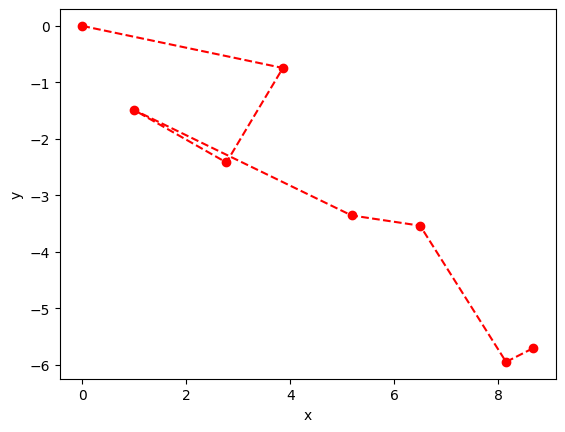

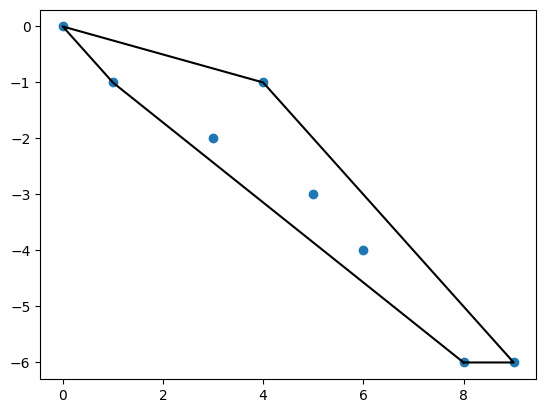

UnboundLocalError: local variable 'area' referenced before assignment

In [289]:
centers_d, centers = get_centers(img_binary, heart_slices, make_plot=True)
dist_mean, dist_std, dist_var, dist_min, dist_max, dist = centers_dis(centers_d)
area = centers_enclosed_area(centers_d, make_plot=True)
print('dist_mean, dist_std, dist_var, dist_min, dist_max, area')
print(dist_mean, dist_std, dist_var, dist_min, dist_max, area)